# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

**Imports**

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from scipy import stats, special
from scipy.stats import norm
from scipy.optimize import brentq

**Load & Preprocess**

In [63]:
HIST_PATH = "../raw/historical.xls"
JUNE_PATH = "../raw/june_forecasts.xls"

hist_raw = pd.read_html(HIST_PATH)[0]
june_raw = pd.read_html(JUNE_PATH)[0]

Inspect

In [64]:
hist_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,721
0,NFP TCH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Summary,NaN,Actual,Economist,NaN,Peter Dixon,NaN,Sonia Meskin,NaN,Nikola Mirtchev,...,NaN,James A Shugg,NaN,John McAuley,NaN,Nash Peyton,NaN,Stephanie Roth,NaN,Crandall/Jordan
2,Release Date,Observation Date,NaN,Firm,As of,NaN,As of,NaN,As of,3d Currency Management Limited,...,As of,Westpac Banking Corp,As of,Wilkinson Boyd Captl Mrkts Inc,As of,Wilmington Trust Company,As of,Wolfe Research LLC,As of,Wrightson ICAP LLC
3,02/04/2000,01/31/2000,387,NaN,--,--,--,--,--,--,...,--,--,02/04/2000,200,--,--,--,--,02/04/2000,225
4,03/03/2000,02/29/2000,43,NaN,--,--,--,--,--,--,...,--,--,02/29/2000,200,--,--,--,--,03/03/2000,180


In [65]:
june_raw.head()

,0,1,2,3,4,5
0,NFP TCH Index,NaN,NaN,NaN,NaN,NaN
1,NaN,Release Date,6/6/2025,NaN,NaN,NaN
2,NaN,Time,08:30,NaN,NaN,NaN
3,NaN,Country/Region,US,NaN,NaN,NaN
4,NaN,Event,Change in Nonfarm Payrolls,NaN,NaN,NaN


Raw data is messy. Want to process this into a long table format for our smart NFP forecasting (where each row is a forecast by a single economist/sell-side institution).

In [66]:
name_row = hist_raw.iloc[1]
firm_row = hist_raw.iloc[2]

In [67]:
base = hist_raw.iloc[3:, :3].copy()
base.columns = ["release_date", "period", "actual"]
base["release_date"] = pd.to_datetime(base["release_date"])
base["period"] = pd.to_datetime(base["period"])
base["actual"] = pd.to_numeric(base["actual"], errors="coerce")

In [68]:
base

,release_date,period,actual
3,2000-02-04,2000-01-31,387
4,2000-03-03,2000-02-29,43
5,2000-04-07,2000-03-31,416
6,2000-05-05,2000-04-30,340
7,2000-06-02,2000-05-31,231
...,...,...,...
302,2025-01-10,2024-12-31,256
303,2025-02-07,2025-01-31,143
304,2025-03-07,2025-02-28,151
305,2025-04-04,2025-03-31,228


In [69]:
# numeric forecast cols
econ_cols = [idx for idx, val in name_row.items()
             if isinstance(val,str) and val not in {'Summary', 'Actual', 'Economist'}
]

In [70]:
# collect long dataframes, one per economist 

long_frames = []

for col in econ_cols:
    asof_col = col - 1
    
    tmp = base.copy()
    
    tmp["economist"] = name_row[col]
    tmp["firm"]      = firm_row[col]
    
    tmp["forecast"]  = pd.to_numeric(hist_raw.iloc[3:, col], errors="coerce")
    
    tmp["asof"]      = pd.to_datetime(hist_raw.iloc[3:, asof_col], errors="coerce")
    
    long_frames.append(tmp)
    
hist_long = pd.concat(long_frames, ignore_index=True)

C:\Users\nwong\AppData\Local\Temp\ipykernel_19360\311849067.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp["asof"]      = pd.to_datetime(hist_raw.iloc[3:, asof_col], errors="coerce")
C:\Users\nwong\AppData\Local\Temp\ipykernel_19360\311849067.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp["asof"]      = pd.to_datetime(hist_raw.iloc[3:, asof_col], errors="coerce")
C:\Users\nwong\AppData\Local\Temp\ipykernel_19360\311849067.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tmp["asof"]      = pd.to_datetime(hist_raw.iloc[3:, asof_col], errors="coerce")
C

In [71]:
hist_long

,release_date,period,actual,economist,firm,forecast,asof
0,2000-02-04,2000-01-31,387,Peter Dixon,NaN,NaN,NaT
1,2000-03-03,2000-02-29,43,Peter Dixon,NaN,NaN,NaT
2,2000-04-07,2000-03-31,416,Peter Dixon,NaN,NaN,NaT
3,2000-05-05,2000-04-30,340,Peter Dixon,NaN,NaN,NaT
4,2000-06-02,2000-05-31,231,Peter Dixon,NaN,340.0,2000-05-30
...,...,...,...,...,...,...,...
96667,2025-01-10,2024-12-31,256,Crandall/Jordan,Wrightson ICAP LLC,150.0,2024-12-20
96668,2025-02-07,2025-01-31,143,Crandall/Jordan,Wrightson ICAP LLC,125.0,2025-01-17
96669,2025-03-07,2025-02-28,151,Crandall/Jordan,Wrightson ICAP LLC,100.0,2025-02-14
96670,2025-04-04,2025-03-31,228,Crandall/Jordan,Wrightson ICAP LLC,80.0,2025-03-14


In [76]:
##Tidy June 2025 release file 

# Build mask to keep valid forecaster rows 
forecast_col = pd.to_numeric(june_raw[3], errors="coerce")

mask = june_raw[0].isna() & forecast_col.notna()

june_core = (
    june_raw.loc[mask, [1,2,3,4,5]]
    .rename(columns = {1: "economist",
                       2: "firm",
                       3: "forecast", 
                       4: "asof", 
                       5: "rank"})
)

june_core["forecast"] = forecast_col[mask]
june_core["asof"] = pd.to_datetime(june_core["asof"],
                                   errors="coerce")

# substitute firm name if economist is missing 
june_core["economist"] = june_core.apply(
    lambda r: r["economist"] if pd.notna(r["economist"]) else f"({r['firm']})",
    axis = 1
)

# Extract NFP print 
actual_mask = june_raw.apply(
    lambda r: r.astype(str).str.contains("Actual", case=False).any(), axis = 1
)
actual_val = (
    pd.to_numeric(june_raw.loc[actual_mask].stack(), errors = "coerce")
                  .dropna()
                  .iloc[0]
)

# hardcode release and reference month 
release_date = pd.to_datetime("2025-06-06") # BLS release day 
period_date = pd.to_datetime("2025-05-01")  # payroll month 

# match hist_long schema for merge

june_long = (
    june_core.assign(
        release_date = release_date,
        period = period_date,
        actual = actual_val
    )
    .loc[:, ["release_date", "period", "economist", "firm", 
             "forecast", "actual", "asof"]]
)

In [77]:
# verify that june matches the historical panel, so that we
june_long

,release_date,period,economist,firm,forecast,actual,asof
22,2025-06-06,2025-05-01,Stan Shipley,Evercore ISI,115.0,139.0,2025-06-05
23,2025-06-06,2025-05-01,Crandall/Jordan,Wrightson ICAP LLC,150.0,139.0,2025-05-16
24,2025-06-06,2025-05-01,Peter G Morici,University of Maryland,120.0,139.0,2025-05-21
25,2025-06-06,2025-05-01,Hugh A Johnson,Hugh Johnson Economics LLC,130.0,139.0,2025-05-23
26,2025-06-06,2025-05-01,Michael R Englund,Action Economics LLC,135.0,139.0,2025-05-23
...,...,...,...,...,...,...,...
96,2025-06-06,2025-05-01,(Vinland Capital Management II Gestora de Recu...,Vinland Capital Management II Gestora de Recur...,135.0,139.0,2025-06-05
97,2025-06-06,2025-05-01,Yonie Fanning,Mizrahi Tefahot Bank Limited,98.0,139.0,2025-06-05
98,2025-06-06,2025-05-01,Nicholas Van Ness,Credit Agricole CIB,115.0,139.0,2025-06-05
99,2025-06-06,2025-05-01,(Japan Digital Design Inc),Japan Digital Design Inc,155.0,139.0,2025-06-05


In [78]:
# Merge/stack dfs (June + historical long formats)

# Stack panels  
nfp_long = pd.concat([hist_long, june_long], ignore_index = True, sort = False)


# Compute forecast error 
nfp_long["error"] = nfp_long["forecast"] - nfp_long["actual"]

# Per release, we only want the last forecast 
econ_forecasts_long = (
    nfp_long
    .sort_values(["release_date", "economist", "asof"])
    .groupby(["release_date", "economist"], as_index=False)
    .tail(1)
    .reset_index(drop=True)
)

In [79]:
df_full = econ_forecasts_long
df_full.head()

,release_date,period,actual,economist,firm,forecast,asof,error
0,2000-02-04,2000-01-31,387.0,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN
1,2000-02-04,2000-01-31,387.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN
2,2000-02-04,2000-01-31,387.0,Alexandre De Azara,Banco UBS SA,NaN,NaT,NaN
3,2000-02-04,2000-01-31,387.0,Alison Lynn Reaser,Point Loma Nazarene University,NaN,NaT,NaN
4,2000-02-04,2000-01-31,387.0,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN


In [ ]:
# Quick sanity checks

# should only have one forecast per economist, per release
assert df_full.duplicated(subset=["release_date", "economist"]).sum() == 0,\
    "Duplicate (release date, economist) combinations detected"

# forecast timestamp has to be before release date. caveat: NA values will make the assertion fail, so we account NAs.
valid_asof = df_full["asof"].notna()
assert (df_full.loc[valid_asof, "asof"] <= df_full.loc[valid_asof, "release_date"]).all(),\
    "Some forecasts have asof (non-NA) after release date."

# each release date should have only one realized (actual) value 
assert (df_full.groupby("release_date")["actual"].nunique() == 1).all(), \
    "Multiple actual values found for the same release date"
    
# check if (release_date, firm) unique, or if there are forecasts from multiple economists from same firm for a given date
#       assertion fails
#assert df_full.duplicated(subset=["release_date", "firm"]).sum() == 0,\
#    "Duplicate (release date, firm) combinations detected"

In [86]:
# dupes_df

Many NA forecasts. Even if (firm, release date) is not unique (multiple economists from same firm), it may just be from carrying NAs.

In [ ]:
# check that each (release_date, firm) has at most 1 non-NA forecast

# non_NA_per_firm = (
#     df_full.assign(non_na = df_full["forecast"].notna())
#     .groupby(["release_date", "firm"])["non_na"]
#     .sum()
# )

# violations = non_NA_per_firm[non_NA_per_firm > 1]

# this fails 
# assert violations.empty, ("Some (release_date, firm) pairs have multiple valid forecasts", violations)

In [ ]:
# check firms and dates that do not have (release_date, firm) uniqueness

# unique_firms = violations.index.get_level_values("firm").unique()
# print("Firms with multiple economists forecasting per date: \n", unique_firms)

# dates = violations.index.get_level_values("release_date").unique()
# print("Dates: \n", dates)

Firms with multiple economists forecasting per date: 
 Index(['Nomura Securities Intl Inc', 'Natixis North America LLC', 'Nord LB',
       'Landesbank Baden-Wuerttemberg', 'Intesa Sanpaolo SpA',
       'Canadian Imperial Bank of Commerce', 'Barclays Capital Inc.',
       'Stifel Nicolaus & Co Inc'],
      dtype='object', name='firm')
Dates: 
 DatetimeIndex(['2000-02-04', '2000-03-03', '2000-04-07', '2000-05-05',
               '2000-06-02', '2000-07-07', '2000-08-04', '2000-09-01',
               '2000-10-06', '2000-11-03',
               ...
               '2021-04-02', '2021-06-04', '2021-08-06', '2021-09-03',
               '2021-10-08', '2021-11-05', '2021-12-03', '2022-02-04',
               '2022-03-04', '2022-04-01'],
              dtype='datetime64[ns]', name='release_date', length=142, freq=None)


In [ ]:
# target_date = pd.Timestamp("2000-02-04")
# target_firm = "Nomura Securities Intl Inc"

# subset = df_full.loc[
#     (df_full["release_date"] == target_date) & 
#     (df_full["firm"] == target_firm)
# ]

# print(subset)

    release_date     period  actual        economist  \
64    2000-02-04 2000-01-31   387.0   David H Resler   
98    2000-02-04 2000-01-31   387.0  Gerald Zukowski   
310   2000-02-04 2000-01-31   387.0     William Quan   

                           firm  forecast       asof  error  
64   Nomura Securities Intl Inc     250.0 2000-02-01 -137.0  
98   Nomura Securities Intl Inc     260.0 2000-02-04 -127.0  
310  Nomura Securities Intl Inc     285.0 2000-02-02 -102.0  


In [93]:
# Sanity output 
# print("NAs: ")
# print(df_full.isna().sum(), "\n")
# print("Rows: ", econ_forecasts_long.shape[0])
# print("Economists: ", econ_forecasts_long['economist'].nunique())
# print("NFP releases: ", econ_forecasts_long['release_date'].nunique())

In [94]:
# get median

median_by_release = (
    df_full.groupby("release_date")["forecast"]
    .median()
    .rename("median_forecast")
)

df_full = df_full.merge(median_by_release, on="release_date", how="left")

In [95]:
df_full.head()

,release_date,period,actual,economist,firm,forecast,asof,error,median_forecast_x,median_forecast_y
0,2000-02-04,2000-01-31,387.0,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,267.5,267.5
1,2000-02-04,2000-01-31,387.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,267.5,267.5
2,2000-02-04,2000-01-31,387.0,Alexandre De Azara,Banco UBS SA,NaN,NaT,NaN,267.5,267.5
3,2000-02-04,2000-01-31,387.0,Alison Lynn Reaser,Point Loma Nazarene University,NaN,NaT,NaN,267.5,267.5
4,2000-02-04,2000-01-31,387.0,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,267.5,267.5


**Data Exploration**

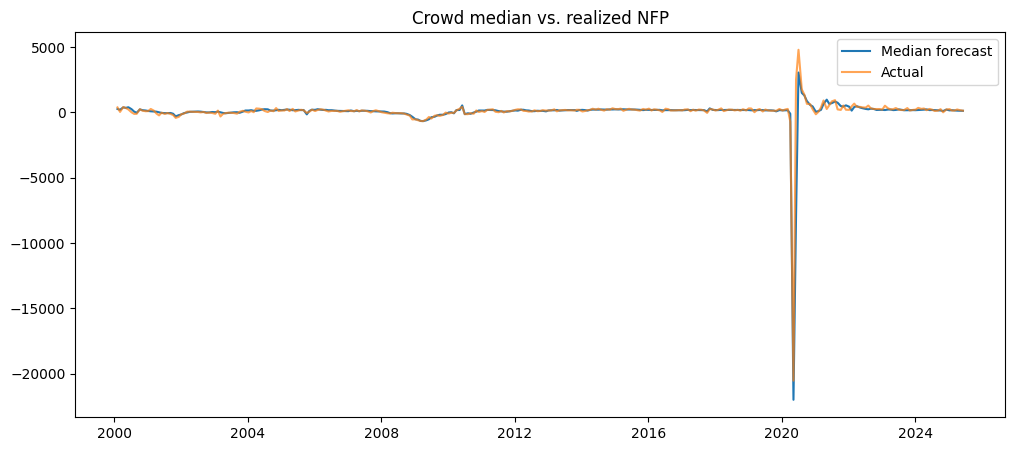

In [23]:
# Crowd median vs actual - check how useful crowd median is as a baseline forecast 
# sets a baseline. we want our inverse MSE ensemble model to beat this on RMSE

median_vs_actual = (
    df.groupby("release_date")
    .agg(crowd_median=("forecast", "median"),
    actual = ("actual", "first"))
    .dropna()
)

plt.figure(figsize=(12,5))
plt.plot(median_vs_actual.index, median_vs_actual["crowd_median"],
label = "Median forecast")
plt.plot(median_vs_actual.index, median_vs_actual["actual"],
label="Actual", alpha=.7)
plt.title("Crowd median vs. realized NFP")
plt.legend()
plt.show()

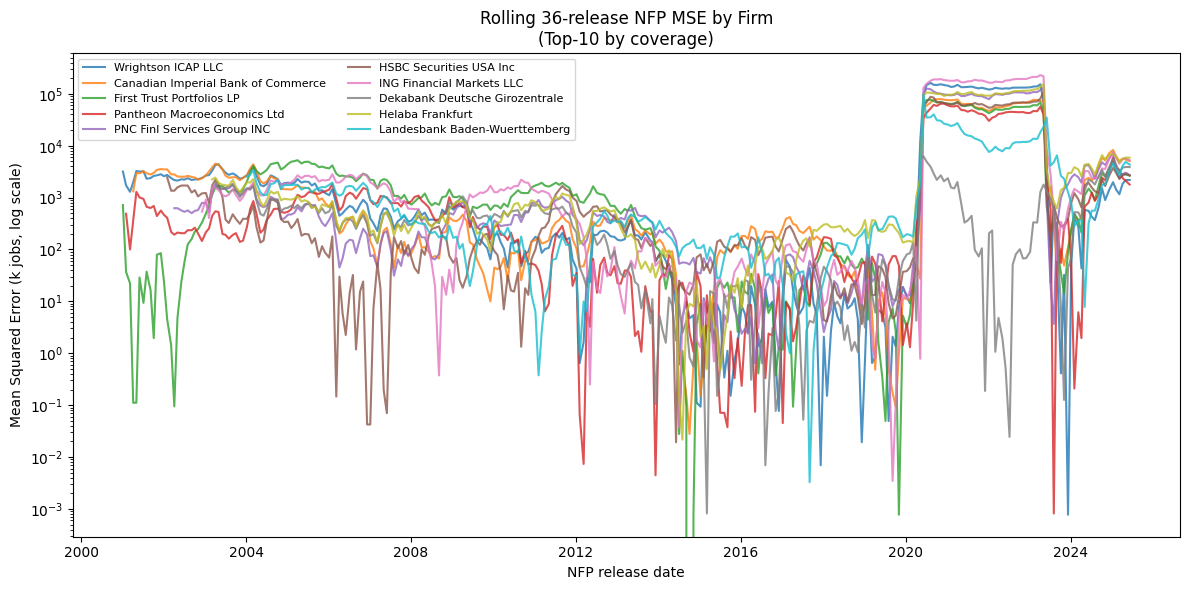

In [24]:
# check which firms have historically been most accurate (top 10 by coverage)

top_n = 10
coverage = (df.groupby("firm")["forecast"]
            .count()
            .sort_values(ascending=False))
top_firms = coverage.head(top_n).index

# error matrix
err_mat = (df.pivot_table(index="release_date",
                    columns="firm",
                    values="error",
                    aggfunc = "median")
           .sort_index()
           [top_firms])

# rolling 36-release MSE
roll_mse = err_mat.rolling(window=36, min_periods=12).mean()**2

plt.figure(figsize=(12,6))
for firm in top_firms:
    plt.plot(roll_mse.index, roll_mse[firm],
             label=firm, alpha=0.8, linewidth=1.5)
    
plt.yscale("log")
plt.title("Rolling 36-release NFP MSE by Firm\n(Top-10 by coverage)")
plt.xlabel("NFP release date")
plt.ylabel("Mean Squared Error (k jobs, log scale)")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

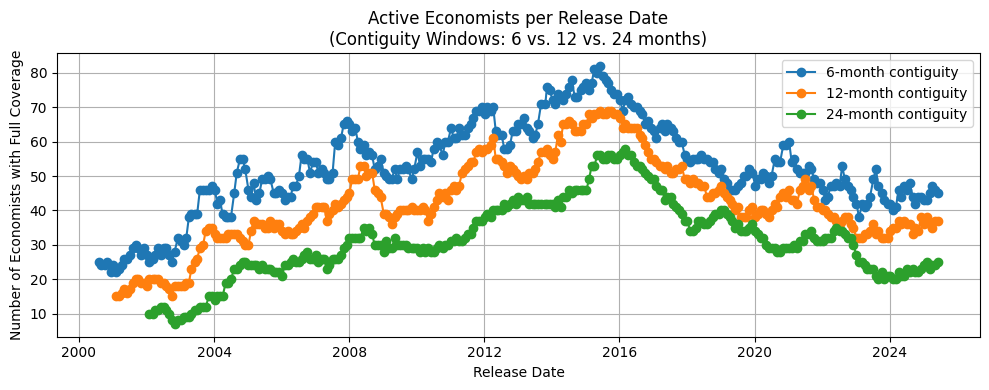

In [25]:
dates = sorted(df["release_date"].unique())

contiguity_windows = [6, 12, 24]
active_counts = {}

for window in contiguity_windows:
    counts = []
    for idx in range(window, len(dates)):
        t      = dates[idx]
        window_dates = dates[idx-window:idx]
        hist   = df[df["release_date"].isin(window_dates)]
        valid  = (
            hist.groupby("economist")["forecast"]
                .apply(lambda s: s.notna().all())
        )
        counts.append((t, valid.sum()))
    active_counts[window] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts]
    )

# Plot both series on the same axes
plt.figure(figsize=(10, 4))
for window, series in active_counts.items():
    plt.plot(series.index, series.values, marker='o', label=f"{window}-month contiguity")

plt.title("Active Economists per Release Date\n(Contiguity Windows: 6 vs. 12 vs. 24 months)")
plt.xlabel("Release Date")
plt.ylabel("Number of Economists with Full Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


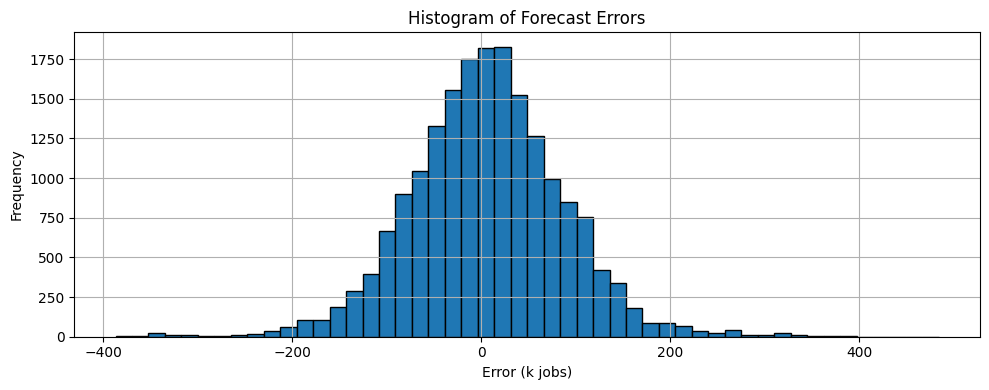

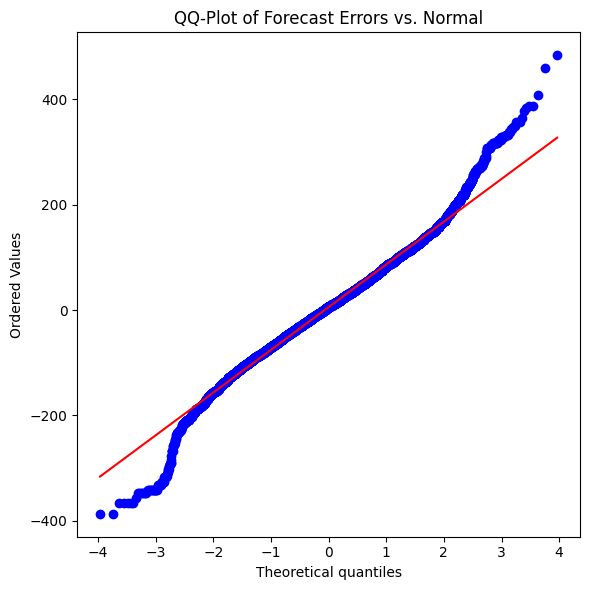

In [97]:
# Error distribution: histogram and QQ plot of forecast errors 
errors = df["error"].dropna().values

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor="black")
plt.title("Histogram of Forecast Errors")
plt.xlabel("Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ‐Plot of Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()


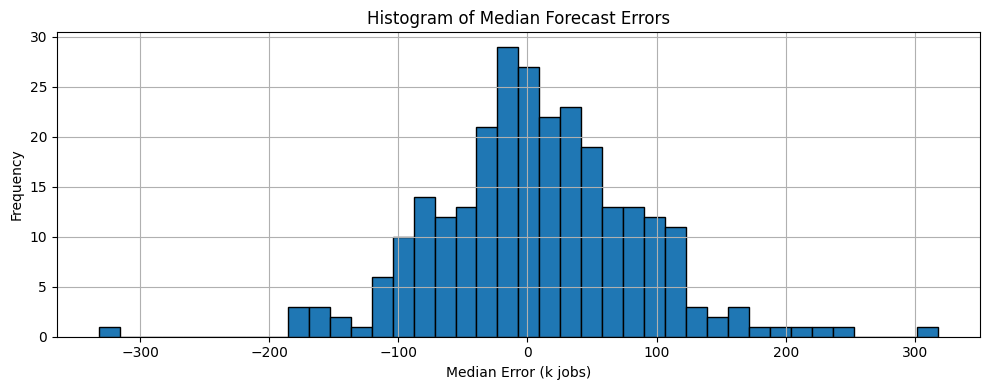

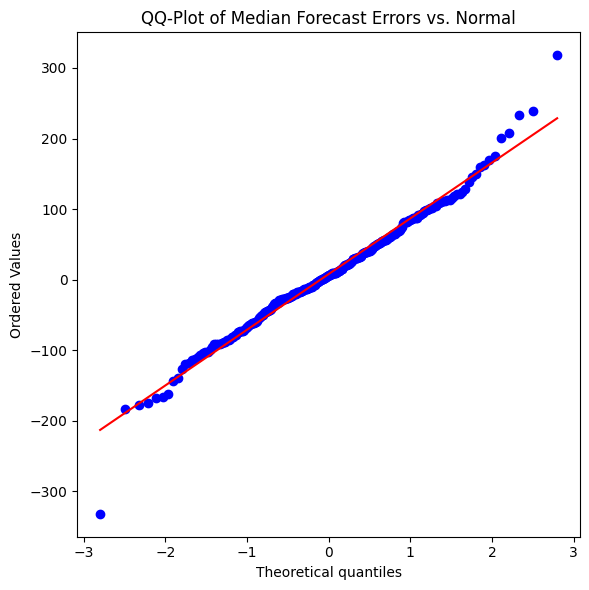

In [36]:
# Compute median forecast errors (one value per release)
median_errors = (
    df
    .drop_duplicates('release_date')  # keep one row per release
    .assign(median_err=lambda d: d['median_forecast'] - d['actual'])
    ['median_err']
    .values
)

# Histogram of median forecast errors
plt.figure(figsize=(10, 4))
plt.hist(median_errors, bins=40, edgecolor='black')
plt.title("Histogram of Median Forecast Errors")
plt.xlabel("Median Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# QQ‐plot of median errors against a Normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(median_errors, dist='norm', plot=plt)
plt.title("QQ‐Plot of Median Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()


**Normality tests**

In [52]:
from scipy.stats import jarque_bera

# --- Jarque-Bera on economist-level errors ----
jb_e_stat, jb_e_p = jarque_bera(errors)
print(f"Jarque–Bera (all economist errors) :  JB = {jb_e_stat:,.2f},  p = {jb_e_p:.4f}")

# --- Jarque-Bera on MEDIAN forecast errors -------------------------
jb_m_stat, jb_m_p = jarque_bera(median_errors)
print(f"Jarque–Bera (median errors)        :  JB = {jb_m_stat:,.2f},  p = {jb_m_p:.4f}")

if jb_m_p < 0.05:
    print("→ Reject normality of median errors at the 5 % level.")
else:
    print("→ Cannot reject normality of median errors at the 5 % level.")
    
    
    
# for reference: JB stat threshold for 5% threshold is approx. 6 


Jarque–Bera (all economist errors) :  JB = 1,963.77,  p = 0.0000
Jarque–Bera (median errors)        :  JB = 32.07,  p = 0.0000
→ Reject normality of median errors at the 5 % level.


## 1.0: Static Forecast (COVID included)

Rolling 6-month fixed window. For every valid economist (for a prediction at time t, has a contiguous 6-month forecast history for previous 6 releases), weight prediction by inverse MSE. 


This implements an out-of-sample error estimate with a rolling 6-month estimation window. Weights don't use information from the target month and actual value at month *t* is unseen. In other words, all errors are "live" errors that could have been observed in real time.

Briefly, the procedure: 
1. Starts at 7th release (for 6 month release prior)
2. From estimation window, keep economists that supplied a forecast for all six months (per contiguity rule)
3. Compute MSE for each economist using errors against already known actuals (no lookahead)
4. Generate forecast for release t 
5. Store OOS evaluation error
6. Roll window forward a month and repeat

RMSE - smart: 623.87 k jobs
RMSE - median:  631.48 k jobs
DM statistic:  -0.92
p-value: 0.3600


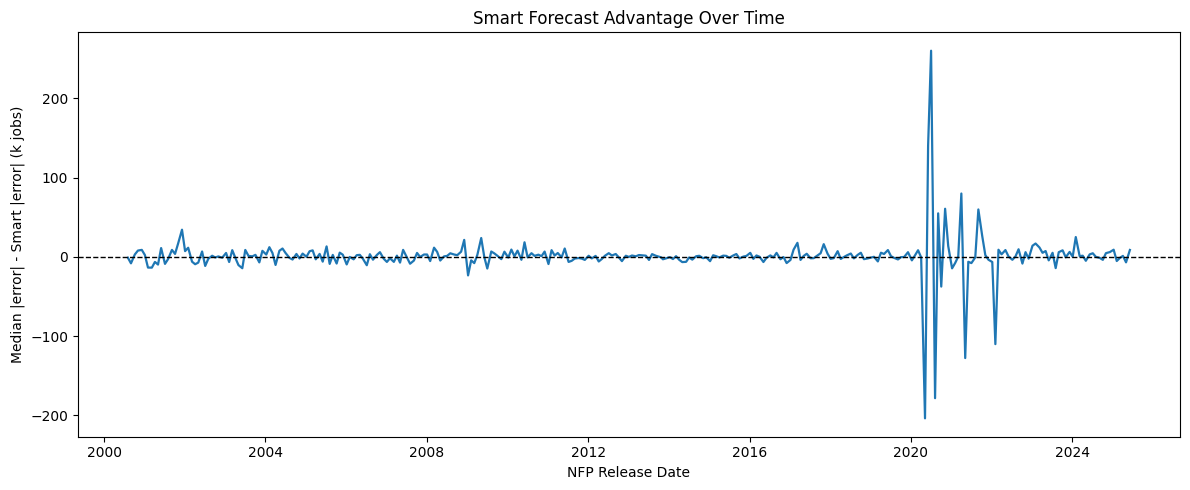

In [101]:
df_full["release_date"] = pd.to_datetime(df_full["release_date"])
dates = np.sort(df_full["release_date"].unique())

records = []        # collect out-of-sample predictions

for idx in range(6, len(dates)):
    t = dates[idx]      # target release 
    window = dates[idx-6:idx]       # six prior releases
    
    hist = df_full[df_full["release_date"].isin(window)]
    
    valid_mask = (hist.groupby("economist")["forecast"]
                  .apply(lambda s: s.notna().all()))
    
    valid_econ = valid_mask[valid_mask].index
    
    mse = (hist[hist["economist"].isin(valid_econ)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(s.dropna()**2))
           .dropna())
    
    if valid_econ.empty:
        continue 
    
    ridge = 1e-6            # prevent weight blow-ups given small estimation window 
    weights = 1 / (mse + ridge)
    weights = weights / weights.sum() # normalize
    
    # target specific values 
    cur = df_full[(df_full["release_date"] == t) & 
             (df_full["economist"].isin(valid_econ))]
    f_t = cur.set_index("economist")["forecast"].dropna()
    
    # safeguard: economist may forecast past 6 releases, but may have no forecast for t
    # align & renormalize weights
    weights = weights[weights.index.isin(f_t.index)] 
    if weights.empty:
        continue
    weights = weights/weights.sum()     # renormalize
    
    yhat_smart = np.dot(weights, f_t.loc[weights.index])
    yhat_median = (df_full.loc[df_full["release_date"] == t, "forecast"].dropna().median())
    y_actual = df_full.loc[df_full["release_date"] == t,
                      "actual"].iloc[0]
    
    records.append((t, yhat_smart, yhat_median, y_actual))
    
oos = pd.DataFrame(records, 
                   columns = ["date", "smart", "median", "actual"])
oos["smart_err"] = oos["smart"] - oos["actual"]
oos["median_err"] = oos["median"] - oos["actual"]

rmse_smart = np.sqrt(np.mean(oos["smart_err"]**2))
rmse_median = np.sqrt(np.mean(oos["median_err"]**2))
print(f"RMSE - smart: {rmse_smart:6.2f} k jobs")
print(f"RMSE - median: {rmse_median: 6.2f} k jobs")

# Diebold-Mariano (DM) test: given two time series of loss, compute loss differential, test if the mean of this series of loss differential is statistically different from 0 

d = oos["smart_err"]**2 - oos["median_err"]**2
dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
p_val = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
print(f"DM statistic: {dm_stat: 6.2f}")
print(f"p-value: {p_val:.4f}")

# Visualize smart forecast advantage 
oos["improvement"] = (oos["median_err"].abs() - 
                      oos["smart_err"].abs())

plt.figure(figsize=(12,5))
plt.plot(oos["date"], oos["improvement"],
         color="tab:blue", linewidth=1.6)

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title("Smart Forecast Advantage Over Time")
plt.xlabel("NFP Release Date")
plt.ylabel("Median |error| - Smart |error| (k jobs)")
plt.tight_layout()
plt.show()

Erratic behavior in COVID and its aftermath. Propose to subset out 2020-2022 to not penalize our model for poor performance in a one-off pandemic.

**Preprocessing**

In [29]:
# Filter out COVID dates --> avoid penalizing for erratic performance in pandemic 

df_filtered = df[~df["release_date"].between("2020-01-01", "2022-12-31")]
df_filtered.head()

,release_date,period,actual,economist,firm,forecast,asof,error
0,2000-02-04,2000-01-31,387.0,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN
1,2000-02-04,2000-01-31,387.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN
2,2000-02-04,2000-01-31,387.0,Alexandre De Azara,Banco UBS SA,NaN,NaT,NaN
3,2000-02-04,2000-01-31,387.0,Alison Lynn Reaser,Point Loma Nazarene University,NaN,NaT,NaN
4,2000-02-04,2000-01-31,387.0,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN


In [30]:
# rename for simplicity
df = df_filtered

In [40]:
# Surprise = actual minus consensus (median forecast) for directional forecasting
df["surprise"] = df["actual"] - df["median_forecast"]

In [ ]:
df.head()

,release_date,period,actual,economist,firm,forecast,asof,error,median_forecast,surprise
0,2000-02-04,2000-01-31,387.0,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,267.5,119.5
1,2000-02-04,2000-01-31,387.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,267.5,119.5
2,2000-02-04,2000-01-31,387.0,Alexandre De Azara,Banco UBS SA,NaN,NaT,NaN,267.5,119.5
3,2000-02-04,2000-01-31,387.0,Alison Lynn Reaser,Point Loma Nazarene University,NaN,NaT,NaN,267.5,119.5
4,2000-02-04,2000-01-31,387.0,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,267.5,119.5


## 1.1: Static Forecast, COVID Filtered Out

Here, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 6, 12, and 24 months


In [58]:
# Prep
df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

windows = [6, 12, 24]  # contiguity windows to test
results = []

for window in tqdm(windows, desc="Contiguity windows"):
    records = []
    # walk‐forward with a tqdm for each window
    for idx in tqdm(range(window, len(dates)), 
                    desc=f"{window}-mo static ensemble", leave=False):
        t = dates[idx]
        window_dates = dates[idx-window:idx]
        hist = df[df["release_date"].isin(window_dates)]
        
        # filter economists with full coverage
        valid = hist.groupby("economist")["forecast"] \
                    .apply(lambda s: s.notna().all())
        valid_econ = valid[valid].index
        if valid_econ.empty:
            continue
        
        # compute inverse‐MSE weights
        mse = (hist[hist["economist"].isin(valid_econ)]
               .groupby("economist")["error"]
               .apply(lambda s: np.nanmean(s**2)))
        ridge = 1e-6
        weights = 1.0 / (mse + ridge)
        weights /= weights.sum()
        
        # current forecasts & align
        cur = df[(df["release_date"] == t) &
                 (df["economist"].isin(valid_econ))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        weights = weights.loc[weights.index.intersection(f_t.index)]
        if weights.empty:
            continue
        weights /= weights.sum()
        
        # point forecasts
        yhat_smart  = np.dot(weights, f_t.loc[weights.index])
        yhat_median = df.loc[df["release_date"] == t, "forecast"] \
                         .dropna().median()
        y_actual    = df.loc[df["release_date"] == t, "actual"].iloc[0]
        
        records.append((t, yhat_smart, yhat_median, y_actual))
    
    # build out‐of‐sample table
    oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]
    
    # compute level‐forecast metrics
    obs          = len(oos)
    mse_smart    = np.mean(oos["smart_err"]**2)
    rmse_smart   = np.sqrt(mse_smart)
    mae_smart    = np.mean(np.abs(oos["smart_err"]))
    mse_median   = np.mean(oos["median_err"]**2)
    rmse_median  = np.sqrt(mse_median)
    mae_median   = np.mean(np.abs(oos["median_err"]))
    
    # directional metrics
    oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
    hits   = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
    hit_rate = hits.mean()
    
    # binomial test (null p=0.5)
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    
    # Pesaran–Timmermann test
    p1   = oos["pred_dir"].mean()
    p2   = oos["actual_dir"].mean()
    c    = (oos["pred_dir"] & oos["actual_dir"]).mean()
    pt_stat = (c - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2 * (1 - stats.norm.cdf(abs(pt_stat)))
    
    # Diebold–Mariano on squared‐error
    d       = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(obs)
    dm_p    = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    
    results.append({
        "window":      window,
        "obs":         obs,
        "MSE(smart)":  mse_smart,
        "RMSE(smart)": rmse_smart,
        "MAE(smart)":  mae_smart,
        "MSE(median)": mse_median,
        "RMSE(median)":rmse_median,
        "MAE(median)": mae_median,
        "HitRate":     hit_rate,
        "Binom_p":     binom_p,
        "PT_stat":     pt_stat,
        "PT_p":        pt_p,
        "DM_stat":     dm_stat,
        "DM_p":        dm_p
    })

# compile and display
res_df = pd.DataFrame(results)
print(res_df.to_string(index=False, float_format="{:.3f}".format))


Contiguity windows:   0%|          | 0/3 [00:00<?, ?it/s]

6-mo static ensemble:   0%|          | 0/263 [00:00<?, ?it/s]

12-mo static ensemble:   0%|          | 0/257 [00:00<?, ?it/s]

24-mo static ensemble:   0%|          | 0/245 [00:00<?, ?it/s]

 window  obs  MSE(smart)  RMSE(smart)  MAE(smart)  MSE(median)  RMSE(median)  MAE(median)  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
      6  263    5826.262       76.330      57.796     5979.951        77.330       58.631    0.563    0.048    2.168 0.030   -1.810 0.070
     12  257    5786.736       76.071      57.849     5955.478        77.172       58.535    0.576    0.018    2.495 0.013   -2.084 0.037
     24  245    5477.681       74.011      56.356     5590.126        74.767       56.720    0.551    0.125    1.652 0.099   -1.210 0.226


In [60]:
for w in [6, 12, 24]:
    # releases that survive the w-month loop
    streak_ok = (
        df.groupby("release_date")
          .filter(lambda x: x["forecast"].notna().size >= 1)["release_date"]
          .unique()
    )
    
    kept_dates = [d for d in dates[w:] if d in streak_ok]
    
    if kept_dates:
        first = pd.to_datetime(kept_dates[0]).date()
        last  = pd.to_datetime(kept_dates[-1]).date()
        print(f"{w}-month run evaluates {len(kept_dates)} releases; "
              f"first = {first}, last = {last}")
    else:
        print(f"{w}-month run keeps no dates (empty panel).")


6-month run evaluates 263 releases; first = 2000-08-04, last = 2025-06-06
12-month run evaluates 257 releases; first = 2001-02-02, last = 2025-06-06
24-month run evaluates 245 releases; first = 2002-02-01, last = 2025-06-06


In [61]:
from collections import defaultdict
import pandas as pd
from tqdm.auto import tqdm

df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

windows = [6, 12, 24]
skipped = defaultdict(list)

for window in tqdm(windows, desc="Checking skipped months"):
    for idx in range(window, len(dates)):
        t = dates[idx]
        # six/12/24–month window of history
        hist = df[df["release_date"].isin(dates[idx-window:idx])]
        
        # economists with forecasts in *all* prior months
        valid = hist.groupby("economist")["forecast"] \
                    .apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            skipped[window].append(t)
            continue
        
        # must also have at least one (non-NA) forecast this month
        if df[(df["release_date"] == t) &
              (df["economist"].isin(econs))]["forecast"].dropna().empty:
            skipped[window].append(t)

# ── PRINT RESULTS ────────────────────────────────────────────────
for w in windows:
    miss = skipped[w]
    if miss:
        print(f"\n{w}-month window skips {len(miss)} releases after its initial warm-up:")
        for d in miss:
            print("  ", pd.to_datetime(d).strftime("%Y-%m-%d"))
    else:
        print(f"\n{w}-month window skips **no** releases after the initial {w}-month warm-up.")


Checking skipped months:   0%|          | 0/3 [00:00<?, ?it/s]


6-month window skips **no** releases after the initial 6-month warm-up.

12-month window skips **no** releases after the initial 12-month warm-up.

24-month window skips **no** releases after the initial 24-month warm-up.


12-month contiguity filter seems to work best

**Stratified Analysis**

In [56]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy import stats

# ── PREP ─────────────────────────────────────────────────────────
df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

# ── BUILD OUT-OF-SAMPLE WITH 12-MONTH CONTIGUITY ─────────────────
records = []
for idx in tqdm(range(12, len(dates)), desc="Static 12-mo ensemble"):
    t            = dates[idx]
    window_dates = dates[idx-12:idx]
    hist         = df[df["release_date"].isin(window_dates)]

    # keep economists with forecasts in all 12 prior months
    valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs = valid[valid].index
    if econs.empty:
        continue

    # 12-month MSE and inverse-MSE weights
    mse     = (
        hist[hist["economist"].isin(econs)]
        .groupby("economist")["error"]
        .apply(lambda s: np.nanmean(s**2))
    )
    ridge   = 1e-6
    weights = 1.0 / (mse + ridge)
    weights /= weights.sum()

    # current forecasts
    cur = df[(df["release_date"] == t) & (df["economist"].isin(econs))]
    f_t = cur.set_index("economist")["forecast"].dropna()

    # align & renormalise
    weights = weights.loc[weights.index.intersection(f_t.index)]
    if weights.empty:
        continue
    weights /= weights.sum()

    # point forecasts & actual
    yhat_smart  = np.dot(weights, f_t.loc[weights.index])
    yhat_median = df.loc[df["release_date"] == t, "forecast"].dropna().median()
    y_actual    = df.loc[df["release_date"] == t, "actual"].iloc[0]

    records.append((t, yhat_smart, yhat_median, y_actual))

# assemble out-of-sample DataFrame
oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
oos["smart_err"]  = oos["smart"]  - oos["actual"]
oos["median_err"] = oos["median"] - oos["actual"]
oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)

# ── STRATIFIED EVALUATION ────────────────────────────────────────
periods = {
    "2000-2005": ("2000-01-01", "2005-12-31"),
    "2010-2015": ("2010-01-01", "2015-12-31"),
    "2015-2019": ("2015-01-01", "2019-12-31"),
    "2023-2025": ("2023-01-01", "2025-12-31")
}

summary = []
for label, (start, end) in tqdm(periods.items(), desc="Stratified periods"):
    sub = oos[(oos["date"] >= start) & (oos["date"] <= end)]
    if sub.empty:
        continue

    # Diebold–Mariano on squared error
    d       = sub["smart_err"]**2 - sub["median_err"]**2
    dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
    dm_p    = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    # Directional metrics
    hits     = (sub["actual_dir"] == sub["pred_dir"]).astype(int)
    n        = len(hits)
    hit_rate = hits.mean()

    # Binomial test (null p=0.5)
    binom_p = stats.binomtest(hits.sum(), n, 0.5).pvalue

    # Pesaran–Timmermann test
    p1      = sub["pred_dir"].mean()
    p2      = sub["actual_dir"].mean()
    c       = (sub["pred_dir"] & sub["actual_dir"]).mean()
    pt_stat = (c - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/n)
    pt_p    = 2 * (1 - stats.norm.cdf(abs(pt_stat)))

    summary.append({
        "Period":  label,
        "Obs":     n,
        "HitRate": hit_rate,
        "Binom_p": binom_p,
        "PT_stat": pt_stat,
        "PT_p":    pt_p,
        "DM_stat": dm_stat,
        "DM_p":    dm_p
    })

res_df = pd.DataFrame(summary)
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Static 12-mo ensemble:   0%|          | 0/257 [00:00<?, ?it/s]

Stratified periods:   0%|          | 0/4 [00:00<?, ?it/s]

   Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
2000-2005   59    0.542    0.603    0.234 0.815   -0.726 0.468
2010-2015   72    0.583    0.195    1.392 0.164   -1.673 0.094
2015-2019   60    0.617    0.092    1.860 0.063   -1.855 0.064
2023-2025   30    0.533    0.856   -0.248 0.804   -1.702 0.089


## Bayesian Model Averaging (BMA)

In [137]:
import numpy as np
import pandas as pd
from scipy import stats, special
from tqdm.auto import tqdm
import itertools

# ── GRID PARAMETERS ─────────────────────────────────────────────
windows     = [6, 12]                              # contiguity windows to test
lambdas     = [0.85, 0.90, 0.95]                   # EWMA decay factors
prior_grid  = [
    {'a0': 1.0, 'b0': 50.0},
    {'a0': 2.0, 'b0': 100.0},
    {'a0': 5.0, 'b0': 200.0}
]                                                 # IG(a0,b0) priors
weight_cap  = 0.20                                # max weight per economist
dist        = 'normal'                            # only Normal likelihood

# ── PREP ─────────────────────────────────────────────────────────
# assume df already has release_date as datetime
# df["release_date"] = pd.to_datetime(df["release_date"])
dates = np.sort(df["release_date"].unique())

# build list of parameter combinations
combos = list(itertools.product(windows, lambdas, prior_grid))

results = []

# ── GRID SEARCH WITH PROGRESS BAR ─────────────────────────────────
for window, lam, prior in tqdm(combos, desc="Grid search", total=len(combos)):
    a0, b0 = prior['a0'], prior['b0']
    start_idx = window
    records = []

    for idx in range(start_idx, len(dates)):
        t_date = dates[idx]
        hist   = df[df["release_date"].isin(dates[idx-window:idx])]

        # contiguity filter
        valid = hist.groupby("economist")["forecast"] \
                    .apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # marginal likelihood (Normal–IG conjugate)
        log_w = {}
        for econ in econs:
            errs = hist.loc[hist["economist"] == econ, "error"].dropna().values
            n    = errs.size
            if n == 0:
                continue
            sse = np.sum(errs**2)
            log_w[econ] = (
                special.gammaln(a0 + 0.5*n)
                - (a0 + 0.5*n) * np.log(b0 + 0.5*sse)
            )

        if not log_w:
            continue

        # posterior model probabilities
        econ_list = list(log_w.keys())
        lw_arr    = np.array([log_w[e] for e in econ_list])
        w_unnorm  = np.exp(lw_arr - lw_arr.max())
        w_ser     = pd.Series(w_unnorm, index=econ_list)
        w_ser    /= w_ser.sum()

        # apply weight cap
        w_ser = w_ser.clip(upper=weight_cap)
        w_ser /= w_ser.sum()
        if w_ser.empty:
            continue

        # current forecasts & align
        cur = df[
            (df["release_date"] == t_date) &
            (df["economist"].isin(w_ser.index))
        ]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w_ser = w_ser.loc[w_ser.index.intersection(f_t.index)]
        if w_ser.empty:
            continue
        w_ser /= w_ser.sum()

        # generate forecasts
        yhat_smart  = (w_ser * f_t).sum()
        yhat_median = f_t.median()
        y_actual    = cur["actual"].iloc[0]
        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # assemble out-of-sample results
    oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
    oos["smart_err"]  = oos["smart"]  - oos["actual"]
    oos["median_err"] = oos["median"] - oos["actual"]

    # performance metrics
    rmse_s  = np.sqrt((oos["smart_err"]**2).mean())
    rmse_m  = np.sqrt((oos["median_err"]**2).mean())
    d       = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
    p_val   = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

    results.append({
        "window":     window,
        "lambda":     lam,
        "a0":         a0,
        "b0":         b0,
        "rmse_smart": rmse_s,
        "rmse_median":rmse_m,
        "dm_stat":    dm_stat,
        "p_value":    p_val
    })

# ── REPORT BEST ───────────────────────────────────────────────────
res_df = pd.DataFrame(results)
best   = res_df.loc[res_df["rmse_smart"].idxmin()]

print("Grid-search results:")
print(res_df.to_string(index=False, float_format="%.3f"))
print("\nBest combination (min smart RMSE):")
print(best.to_frame().T.to_string(index=False, float_format="%.3f"))


Grid search:   0%|          | 0/18 [00:00<?, ?it/s]

Grid-search results:
 window  lambda    a0      b0  rmse_smart  rmse_median  dm_stat  p_value
      6   0.850 1.000  50.000      76.237       76.854   -0.592    0.554
      6   0.850 2.000 100.000      76.636       76.854   -0.174    0.862
      6   0.850 5.000 200.000      77.353       76.854    0.299    0.765
      6   0.900 1.000  50.000      76.237       76.854   -0.592    0.554
      6   0.900 2.000 100.000      76.636       76.854   -0.174    0.862
      6   0.900 5.000 200.000      77.353       76.854    0.299    0.765
      6   0.950 1.000  50.000      76.237       76.854   -0.592    0.554
      6   0.950 2.000 100.000      76.636       76.854   -0.174    0.862
      6   0.950 5.000 200.000      77.353       76.854    0.299    0.765
     12   0.850 1.000  50.000      74.891       76.436   -1.407    0.160
     12   0.850 2.000 100.000      74.916       76.436   -1.251    0.211
     12   0.850 5.000 200.000      74.992       76.436   -0.970    0.332
     12   0.900 1.000  50.000 

## Model 2: EWMA forecasting

In [336]:
# ── PARAMETERS ───────────────────────────────────────────────────
init_var    = 10000.0                    # starting EWMA variance (k^2 jobs^2)
ridge       = 1e-6                        # variance floor
lambdas     = [0.80, 0.85, 0.90, 0.95, 0.99]
windows     = [6, 12]        # contiguity window
weight_caps = [0.1]

# ── PREP ─────────────────────────────────────────────────────────
df_filtered["release_date"] = pd.to_datetime(df_filtered["release_date"])
dates = np.sort(df_filtered["release_date"].unique())
start_idx = max(windows)

results = []

# ── GRID SEARCH ──────────────────────────────────────────────────
for window in windows:
    for lam in lambdas:
        for cap in weight_caps:
            ewma_var = pd.Series(init_var, index=df_filtered["economist"].unique())
            records  = []

            for idx in range(start_idx, len(dates)):
                t       = dates[idx]
                last_dt = dates[idx - 1]
                hist    = df_filtered[df_filtered["release_date"].isin(dates[idx-window:idx])]

                valid = hist.groupby("economist")["forecast"] \
                            .apply(lambda s: s.notna().all())
                valid_econ = valid[valid].index
                if valid_econ.empty:
                    continue

                last_err = (
                    df_filtered[df_filtered["release_date"] == last_dt]
                      .set_index("economist")["error"]
                )
                ewma_var.loc[last_err.index] = (
                    lam * ewma_var.loc[last_err.index] +
                    (1 - lam) * (last_err**2)
                )

                var_i   = ewma_var.loc[valid_econ].clip(lower=ridge)
                w       = 1.0 / var_i
                w       = np.minimum(w, cap)
                w       = w / w.sum()

                cur = df_filtered[
                    (df_filtered["release_date"] == t) &
                    (df_filtered["economist"].isin(valid_econ))
                ]
                f_t = cur.set_index("economist")["forecast"].dropna()
                w   = w.loc[w.index.isin(f_t.index)]
                if w.empty:
                    continue
                w = w / w.sum()

                yhat_s = np.dot(w, f_t.loc[w.index])
                yhat_m = f_t.median()
                y_act  = cur["actual"].iloc[0]
                records.append((t, yhat_s, yhat_m, y_act))

            oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
            oos["smart_err"]  = oos["smart"]  - oos["actual"]
            oos["median_err"] = oos["median"] - oos["actual"]

            rmse_s  = np.sqrt((oos["smart_err"]**2).mean())
            rmse_m  = np.sqrt((oos["median_err"]**2).mean())
            d       = oos["smart_err"]**2 - oos["median_err"]**2
            dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
            p_val   = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

            results.append({
                "window":      window,
                "lambda":      lam,
                "weight_cap":  cap,
                "rmse_smart":  rmse_s,
                "rmse_median": rmse_m,
                "dm_stat":     dm_stat,
                "p_value":     p_val
            })

# compile and report
res_df = pd.DataFrame(results)
best  = res_df.loc[res_df["rmse_smart"].idxmin()]

print("Grid-search results:")
print(res_df.to_string(index=False, float_format="%.3f"))
print("\nBest combination (min smart RMSE):")
print(best.to_frame().T.to_string(index=False, float_format="%.3f"))


C:\Users\nwong\AppData\Local\Temp\ipykernel_26340\3324677288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["release_date"] = pd.to_datetime(df_filtered["release_date"])


Grid-search results:
 window  lambda  weight_cap  rmse_smart  rmse_median  dm_stat  p_value
      6   0.800       0.100     145.530       76.692   19.974    0.000
      6   0.850       0.100     145.630       76.692   20.795    0.000
      6   0.900       0.100     145.679       76.692   20.724    0.000
      6   0.950       0.100     145.636       76.692   19.427    0.000
      6   0.990       0.100     145.470       76.692   17.219    0.000
     12   0.800       0.100     114.631       76.436    1.816    0.069
     12   0.850       0.100     114.948       76.436    2.532    0.011
     12   0.900       0.100     115.246       76.436    3.266    0.001
     12   0.950       0.100     115.561       76.436    4.122    0.000
     12   0.990       0.100     115.903       76.436    5.071    0.000

Best combination (min smart RMSE):
 window  lambda  weight_cap  rmse_smart  rmse_median  dm_stat  p_value
 12.000   0.800       0.100     114.631       76.436    1.816    0.069


## Distribution Forecasting via Gaussian Mixture Model

Build Gaussian-mixture predictive distribution for each release.

**Motivation**<br>
Instead of point forecasting, we can use a gaussian mixture model to forecast a probability distribution 

**Background**<br>
Briefly: a Gaussian mixture model treats each forecaster as a mini-model whose uncertainty is normal. 
- Each economist represents a tiny probabilistic model. Point forecast tells us where economist i thinks payrolls will land. Recent RMSE tells us how wide a credible band we should give them. 
- Decide how much weight to give each bell via inverse MSE weighting 
- Blend the bells (Add each normal)
- When we have this mapped density, we can extract: CDF (integration), get quantiles, get tail risks, draw random samples

Here, we build the Gaussian-mixture model with the same 6 month contiguity and inverse-MSE weighting scheme.

In [306]:
df_filtered

,release_date,period,actual,economist,firm,forecast,asof,error,median_forecast_x,median_forecast_y,median_forecast
0,2000-02-04,2000-01-31,387.0,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,267.5,267.5,267.5
1,2000-02-04,2000-01-31,387.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,267.5,267.5,267.5
2,2000-02-04,2000-01-31,387.0,Alexandre De Azara,Banco UBS SA,NaN,NaT,NaN,267.5,267.5,267.5
3,2000-02-04,2000-01-31,387.0,Alison Lynn Reaser,Point Loma Nazarene University,NaN,NaT,NaN,267.5,267.5,267.5
4,2000-02-04,2000-01-31,387.0,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,267.5,267.5,267.5
...,...,...,...,...,...,...,...,...,...,...,...
96746,2025-06-06,2025-05-01,139.0,Uwe Duerkop,Berliner Sparkasse,75.0,2025-06-02,-64.0,126.0,126.0,126.0
96747,2025-06-06,2025-05-01,139.0,William Adams,Comerica Bank,125.0,2025-06-02,-14.0,126.0,126.0,126.0
96748,2025-06-06,2025-05-01,139.0,Yongxin Chen,Japan Post Insurance Co Ltd,150.0,2025-05-23,11.0,126.0,126.0,126.0
96749,2025-06-06,2025-05-01,139.0,Yonie Fanning,Mizrahi Tefahot Bank Limited,98.0,2025-06-05,-41.0,126.0,126.0,126.0


In [274]:
df = df_filtered

In [277]:
dates = np.sort(df["release_date"].unique())

mixtures = {}

for idx in range(6, len(dates)):
    t = dates[idx]
    window = dates[idx-6:idx]
    
    # slice six month history
    hist = df[df["release_date"].isin(window)]
    
    # contiguity filter 
    valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    valid_econ = valid[valid].index
    if valid_econ.empty:
        continue
    
    # compute MSE over the window 
    mse = (hist[hist["economist"].isin(valid_econ)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean((s.dropna())**2))
           .dropna())
    
    if mse.empty:
        continue
    
    # inverse mse weighting
    w = 1.0/(mse + 1e-6)
    w = w/w.sum()
    
    # get current forecasts for t, align + renormalize
    cur = df[(df["release_date"] == t) & 
             (df["economist"].isin(valid_econ))]
    f_t = cur.set_index("economist")["forecast"].dropna()
    w = w.loc[w.index.isin(f_t.index)]
    
    if w.empty:
        continue
    
    w = w/w.sum()
    
    # mixture params
    mixtures[t] = {
        "weights": w.values,
        "means": f_t.loc[w.index].values,
        "vars": mse.loc[w.index].values
    }

In [279]:
#--------------------
# Helper function: get CDF at x 
#--------------------

def mixture_cdf(x, weights, means, variances):
    """
    Compute CDF of a Gaussian mixture at value x.
    """
    sigmas = np.sqrt(variances)
    return np.sum(weights * norm.cdf(x, loc=means, scale = sigmas))

In [281]:
#--------------------
# Quantile function for a given date
#--------------------

def get_quantiles(mixtures, date, probs):
    """
    Return quantiles for 'date' at probabilities in 'probs'
    @param mixtures: dict as built by GMM code, mixtures[date] = {"weights, "means", "vars"}
    @param date: Release date of target
    @param prob: sequence of float representing quantile levels (e.g. [0.25, 0.5, 0.75])
    """
    params = mixtures[date]
    w, m, v = params["weights"], params["means"], params["vars"]
    
    # bounds for root finding
    delta = 5 * np.sqrt(v.max())
    lo = m.min() - delta
    hi = m.max() + delta
    
    def find_q(p):
        return brentq(lambda x: mixture_cdf(x, w, m, v) - p, lo, hi)
    
    q_vals = [find_q(p) for p in probs]
    
    return pd.Series(q_vals, index=probs)
    

In [282]:
#--------------------
# Tail probabilities 
#--------------------

def get_tail_probs(mixtures, date, thresholds):
    """
    Return P(Y <= threshold) and P(Y >= threshold) for each threshold. 
    @param mixtures: dictionary built by GMM, as above
    @param date: release date
    @thresholds: sequence of float representing jobs (k) levels to compute tail probabilities 
    """
    params = mixtures[date]
    w, m, v = params["weights"], params["means"], params["vars"]
    
    p_le = [mixture_cdf(t, w, m, v) for t in thresholds]
    return pd.DataFrame({
        "threshold": thresholds,
        "P_le": p_le,
        "P_ge": [1-p for p in p_le]
    })

In [294]:
plot_date = dates[-1]           # let's try distribution forecasting for the most recent relase (June 6)


# Quartiles 
quartiles = get_quantiles(mixtures, plot_date, probs=[0.25, 0.5, 0.75])

print("Quartiles:\n", quartiles)

Quartiles:
 0.25     92.095180
0.50    135.986634
0.75    178.316179
dtype: float64


In [290]:
# Deciles 

deciles = get_quantiles(mixtures, plot_date, probs=np.arange(0.1, 1.0, 0.1))
print("Deciles:\n", deciles)

Deciles:
 0.1     51.168651
0.2     80.973923
0.3    101.998029
0.4    119.685524
0.5    135.986634
0.6    152.060576
0.7    169.017917
0.8    188.613970
0.9    215.651560
dtype: float64


In [293]:
# Tail probabilities: custom thresholds 

tails = get_tail_probs(mixtures, plot_date, thresholds=[0, 100, 200, 300])
print("Tail probabilities:\n", tails)

Tail probabilities:
    threshold      P_le      P_ge
0          0  0.022624  0.977376
1        100  0.289523  0.710477
2        200  0.847797  0.152203
3        300  0.994251  0.005749


In [299]:
oos

,date,smart,median,actual,smart_err,median_err
0,2000-08-04,68.620063,67.5,-108.0,176.620063,175.5
1,2000-09-01,-16.724194,-25.0,-105.0,88.275806,80.0
2,2000-10-06,237.906172,235.0,252.0,-14.093828,-17.0
3,2000-11-03,167.162469,175.0,137.0,30.162469,38.0
4,2000-12-08,141.303291,150.0,94.0,47.303291,56.0
...,...,...,...,...,...,...
258,2025-02-07,177.845951,172.5,143.0,34.845951,29.5
259,2025-03-07,158.964143,157.5,151.0,7.964143,6.5
260,2025-04-04,141.134108,140.0,228.0,-86.865892,-88.0
261,2025-05-02,130.465912,137.5,177.0,-46.534088,-39.5


**DM Test for Mixture Model**

Run a Diebold-Mariano test on log-score differentials

In [296]:
# Benchmark sigma 
sigma_med = np.sqrt(np.mean(oos["median_err"]**2))

# Collect log-score for smart (GMM) vs. benchmark 
ls_smart, ls_bench, ds = [], [], []

for t, params in mixtures.items():
    # actual print 
    y = df.loc[df["release_date"] == t, "actual"].iloc[0]
    
    # smart density at y 
    w = params["weights"]
    m = params["means"]
    v = params["vars"]
    
    dens_smart = np.sum(w * norm.pdf(y, loc=m, scale=np.sqrt(v)))
    ls_smart.append(np.log(dens_smart))
    
    # benchmark density at y (Normal with median forecast & sigma_med)
    mu_b = df.loc[df["release_date"] == t, "median_forecast"].iloc[0]
    dens_bench = norm.pdf(y, loc=mu_b, scale = sigma_med)
    ls_bench.append(np.log(dens_bench))
    
    # record date
    ds.append(t)

scores = pd.DataFrame({
    "date":     ds, 
    "ls_smart":       ls_smart,
    "ls_bench":         ls_bench
})
scores["d"] = scores["ls_smart"] - scores["ls_bench"]   # score differential 

# DM test on log-score logg 
d = scores["d"]
dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))

print("DM on log-predictive scores")
print(f"DM statistic: {dm_stat:.3f}")
print(f"p-value : {p_value: .4f}")

DM on log-predictive scores
DM statistic: -0.692
p-value :  0.4891
